<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr/modely_RP/R_toam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pynverse

  Created wheel for pynverse: filename=pynverse-0.1.4.4-cp36-none-any.whl size=6350 sha256=8fdaf810d3a5a3e1c5e8fda560a7ecc38f4db6f3d4dfb99a2d51d65627ae3cae
  Stored in directory: /root/.cache/pip/wheels/80/ab/86/ec93f37613f012ba3e65c2bbd67e5c54cbc00d237574100c24
Successfully built pynverse


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad


from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from pynverse import inversefunc

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')

tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)
tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

tilyvoatana = tilyvoafar.get_group('Antananarivo')
tilyvoatana.set_index('Daty', inplace=True)
tilyvoatana.index = pd.to_datetime(tilyvoatana.index)

tilyvoatoa = tilyvoafar.get_group('Toamasina')
tilyvoatoa.set_index('Daty', inplace=True)
tilyvoatoa.index = pd.to_datetime(tilyvoatoa.index)


path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Voa vaovao (observed incidence)
Ivaotoa = tilyvoatoa['Voatomb']

dIvao = pd.DataFrame(data =Ivaotoa)

# Hoan'ny taha sorisoritry ny fifindrana (infectioness profile distribution)

daty_data_manom = datetime.date(2020,5,6)
daty_data_mifar = datetime.date(2020,6,14)

datyt = daty_data_mifar 

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Planning tool: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

#discr_si1 = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0) 
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1, (t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1, k):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = Isi(t+1, t - daty_data_manom + 2)*(1/si_sc + Isi(t,k))/(1 + si(t+1, t - daty_data_manom + 2)*(1/si_sc + Isi(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))*(1/si_sc + tlsi(t,k))/(1 + lsi(t+datetime.timedelta(days = 1))*(1/si_sc + tlsi(t,k)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Voatomb'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [5]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

# for i in range(8):
# t = t_mif - i - 1
# k = 9

APEt91 = []
Prt91 = []

APE91 = 0

for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2) - 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = round(((daty_data_mifar - daty_data_manom).days + 1)/2)
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

# for i in range(9):
# t = t_mif - 1 - 9 + 1 - i
# k = t_mif - t - 2*i
APEt92 = []
Prt92 = []

APE92 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2)-1):
  t = daty_data_mifar - datetime.timedelta(days = 1) - datetime.timedelta(days = ((daty_data_mifar - daty_data_manom).days + 1)/2) + datetime.timedelta(days = 1) - datetime.timedelta(days = i)
  k = (daty_data_mifar - t - datetime.timedelta(days = 2*i)).days
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k) ,t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0
# so that pnb(t_man + 1, 2) = 0 and 

For k = 9, APE91 = 1750.288549846501
APEt91 = [(20.008699515988013, datetime.date(2020, 6, 13)), (45.46365679510063, datetime.date(2020, 6, 12)), (39.39106940648244, datetime.date(2020, 6, 11)), (111.43251599753373, datetime.date(2020, 6, 10)), (87.07290917575685, datetime.date(2020, 6, 9)), (214.75347123946796, datetime.date(2020, 6, 8)), (28.481186780700227, datetime.date(2020, 6, 7)), (48.60728583236925, datetime.date(2020, 6, 6)), (110.66608293266295, datetime.date(2020, 6, 5)), (28.081841165935046, datetime.date(2020, 6, 4)), (145.29236642038956, datetime.date(2020, 6, 3)), (177.5537173680977, datetime.date(2020, 6, 2)), (18.833557667398498, datetime.date(2020, 6, 1)), (109.24899859172994, datetime.date(2020, 5, 31)), (6.1121498954352305, datetime.date(2020, 5, 30)), (134.11948645614603, datetime.date(2020, 5, 29)), (205.53589900775688, datetime.date(2020, 5, 28)), (144.33057847248176, datetime.date(2020, 5, 27)), (75.303077125068, datetime.date(2020, 5, 26))]
Prt91 = [2.043300353

In [6]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

APEk1 = [2781.2097658698704, 2819.3574585426804, 2838.8867150470774, 2821.442702674885, 2808.858894998378, 2781.464676750848, 2768.8208243081976]
APEk2 = [11.195080941880377, 19.34177107995548, 21.62815861244658, 28.212067242092523, 31.141164578590647, 48.711266003490344, 52.89242475982877]


In [7]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = 2726.362273502696
APEk = [2792.4048468117508, 2838.699229622636, 2860.514873659524, 2849.6547699169773, 2840.000059576969, 2830.1759427543384, 2821.7132490680265]
APE = [2792.4048468117508, 2838.699229622636, 2860.514873659524, 2849.6547699169773, 2840.000059576969, 2830.1759427543384, 2821.7132490680265, 2726.362273502696]
9


# Choice of the prior hyperparameters

In [0]:
  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


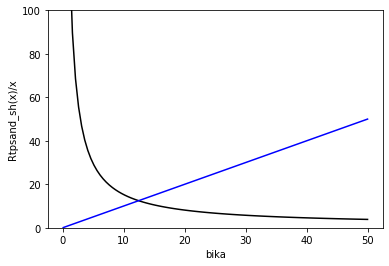

In [9]:
# Variation of Rtpsand_sh(x)/x

datyab = daty_data_mifar

# 100 linearly spaced numbers
x = np.linspace(0.1,50,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, func_sh(datyab)(x)/x, 'k')
plt.plot(x, x, 'b')

ax.set_ylim(0, 100)
ax.set(xlabel ='bika', ylabel = "Rtpsand_sh(x)/x")


# show the plot
plt.show()

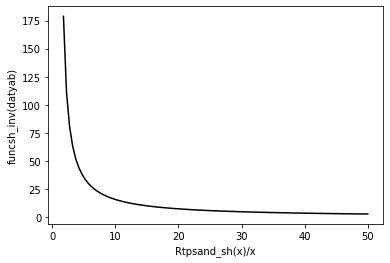

In [10]:
# Variation of funcsh_inv(datyab)


# 100 linearly spaced numbers
x = np.linspace(1.8,50,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, funcsh_inv(datyab)(x), 'k')

ax.set(xlabel ='Rtpsand_sh(x)/x', ylabel = "funcsh_inv(datyab)")


# show the plot
plt.show()

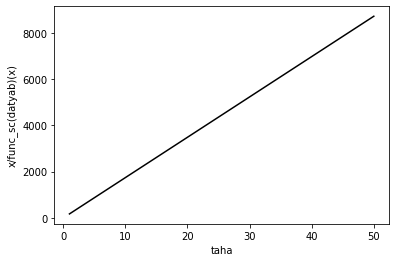

In [11]:
# Variation of x/funcsh_inv(datyab)(x)


# 100 linearly spaced numbers
x = np.linspace(1,50,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x/(func_sc(datyab)(x)), 'k')


ax.set(xlabel ='taha', ylabel = "x/func_sc(datyab)(x)")


# show the plot
plt.show()

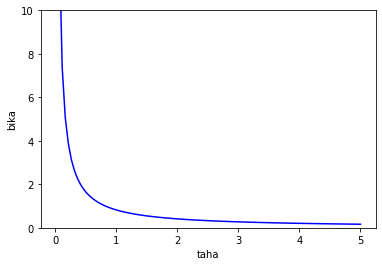

In [12]:
# Curve of (shape, scale) for which the prior mean is equal to the posterior mean

# 100 linearly spaced numbers
x = np.linspace(0.01,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, funcsh_inv(datyab)(x/func_sc(datyab)(x)+0.1), 'blue')

ax.set_ylim(0,10)
ax.set(xlabel ='taha', ylabel = "bika")

plt.savefig(path_to_save+'ab146_toam.eps')

# show the plot
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


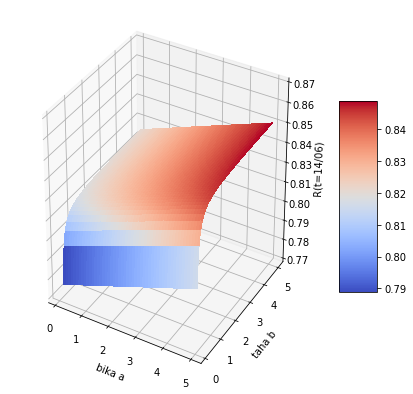

In [15]:
# Variation of R(datyab) with rapport to the prior parameters

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.77, 0.87)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=14/06)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt146_toam.eps')

plt.show()

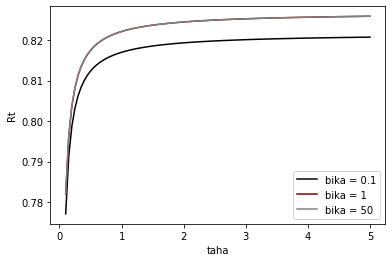

In [16]:
# Variation of R(t) with rapport to the shape parameter a

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the functions
plt.plot(x, func_sh(datyab)(0.1)*func_sc(datyab)(x), 'k', label ="bika = 0.1")
plt.plot(x, func_sh(datyab)(1)*func_sc(datyab)(x), 'maroon', label= 'bika = 1')
plt.plot(x, func_sh(datyab)(1)*func_sc(datyab)(x), 'grey', label= 'bika = 50')

ax.set(xlabel ='taha', ylabel = "Rt")
ax.legend(loc= 'lower right')

# show the plot
plt.show()

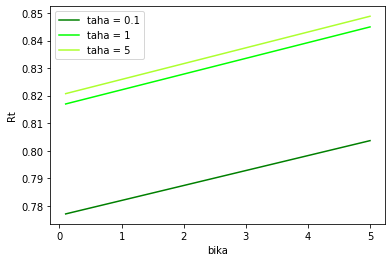

In [17]:
# Variation of R(t) with rapport to the shape prior parameter a

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the functions
plt.plot(x, func_sh(datyab)(x)*func_sc(datyab)(0.1), 'green', label ="taha = 0.1")
plt.plot(x, func_sh(datyab)(x)*func_sc(datyab)(1), 'lime',  label ="taha = 1")
plt.plot(x, func_sh(datyab)(x)*func_sc(datyab)(5), 'greenyellow', label ="taha = 5")

ax.set(xlabel ='bika', ylabel = "Rt")
ax.legend(loc= 'upper left')


# show the plot
plt.show()

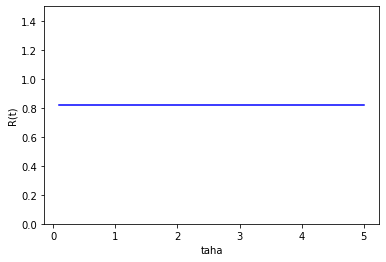

taha* = 1
R(t= 2020-06-14 ) = 0.8210994779546452 = bika*


In [18]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,1.5)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


# Two regions for the prior parameters 

## Blue area

In [0]:
# Prior Gamma distribution of Rt

Rtpr_sh = 0.1 # shape
Rtpr_sc = 0.1 # scale

# Posterior distribution for Rt

# Shape parameter :
def Rtps_sh(t):
   return Rtpr_sh + Ireh(t,kk)

# Scale
def Rtps_sc(t):
  return 1/(1/Rtpr_sc + tlsi(t,kk))

# mean
def Rtps_salan(t):
  return Rtps_sh(t)*Rtps_sc(t)

# 95th and 5th percentiles

def perc95st(t):
  return gengamma.ppf(0.95, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))

def perc05st(t):
  return gengamma.ppf(0.05, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))


def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", datyt, ':', Rtps_sal(datyt))

print("Salan'isa R hoan'ny", datyt, ':', Rtps_salan(datyt))

In [0]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs(Rtps_sh(t), 1, loc = 0,  scale =Rtps_sc(t)) for j in range(400)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


In [0]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(18, 18))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Toamasina")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'Rt3596g_toam.eps')
plt.show()

In [0]:
# Plotting of the last 10 days from daty_data_mifar

fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst[len(daty_lst)-10:len(daty_lst)], data_Rt_lst[len(daty_lst)-10:len(daty_lst)], color='white', width=0.2, showfliers=False, ax=ax)
#ax.plot(daty_lst, sal_Rt, 'green',  marker =9,ls = 'None')
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")
#ax.fill_between(daty_lst10, perc05st_lst10, perc95st_lst10, alpha=0.08, color="tab:grey")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Toamasina")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'R3510610g_toam.eps')
plt.show()

## Red area

In [0]:
# Prior Gamma distribution of Rt

Rtpr_sh = 5 # shape
Rtpr_sc = 5 # scale

# Posterior distribution for Rt

# Shape parameter :
def Rtps_sh(t):
   return Rtpr_sh + Ireh(t,kk)

# Scale
def Rtps_sc(t):
  return 1/(1/Rtpr_sc + tlsi(t,kk))

# mean
def Rtps_salan(t):
  return Rtps_sh(t)*Rtps_sc(t)

# 95th and 5th percentiles

def perc95st(t):
  return gengamma.ppf(0.95, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))

def perc05st(t):
  return gengamma.ppf(0.05, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))


def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", datyt, ':', Rtps_sal(datyt))

print("Salan'isa R hoan'ny", datyt, ':', Rtps_salan(datyt))

In [0]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs(Rtps_sh(t), 1, loc = 0,  scale =Rtps_sc(t)) for j in range(400)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


In [0]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst[len(daty_lst)-10:len(daty_lst)], data_Rt_lst[len(daty_lst)-10:len(daty_lst)], color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Toamasina")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt35106m_toam.eps')
plt.show()

In [0]:
# Plotting of the last 10 days from daty_data_mifar

fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst[len(daty_lst)-10:len(daty_lst)], data_Rt_lst[len(daty_lst)-10:len(daty_lst)], color='white', width=0.2, showfliers=False, ax=ax)
#ax.plot(daty_lst, sal_Rt, 'green',  marker =9,ls = 'None')
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")
#ax.fill_between(daty_lst10, perc05st_lst10, perc95st_lst10, alpha=0.08, color="tab:grey")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Toamasina")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'R3510610m_toam.eps')
plt.show()

# Prior parameters corresponding to the equality of prior and posterior means

In [19]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

daty_oh1 = datetime.date(2020,6,4)

print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))


print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))

Salan'isa R hoan'ny 2020-06-04 : 0.9768415080240679
Kartily @ 75% R hoan'ny 2020-06-04 : 1.022172264516896
Kartily @ 25% R hoan'ny 2020-06-04 : 0.9297626941109439
Salan'isa R hoan'ny 2020-06-14 : 0.8210994779360284
Kartily @ 75% R hoan'ny 2020-06-14 : 0.8661850186949973
Kartily @ 25% R hoan'ny 2020-06-14 : 0.7739405561789933


In [0]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(100)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


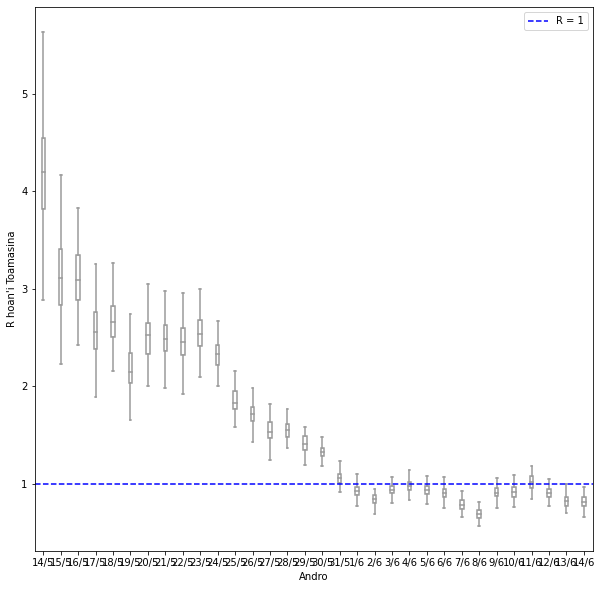

In [23]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Toamasina")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt35146_toam.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


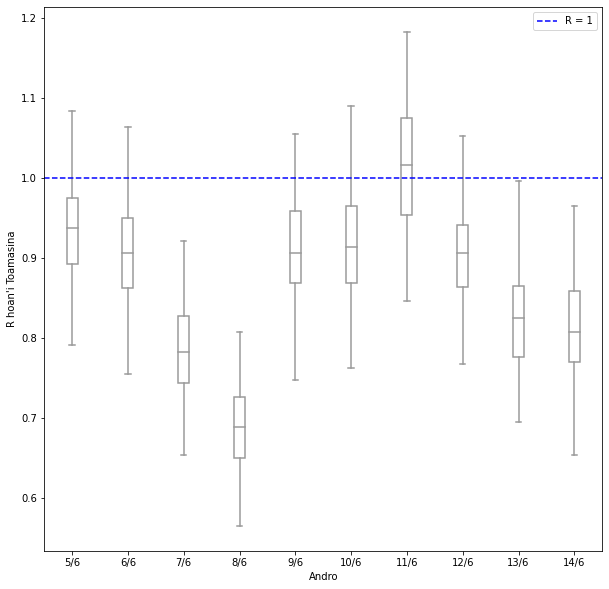

In [25]:
# Plotting the last 10 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst[len(daty_lst)-10:len(daty_lst)], data_Rt_lst[len(daty_lst)-10:len(daty_lst)], color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Toamasina")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt3514610_toam.eps')
plt.show()

## Boundaries for the next 7 days

In [0]:
daty_amba = datetime.date(2020,6,8)
daty_ambo = datetime.date(2020,6,11)


In [0]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)

daty_vina = daty_ambo

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_vina)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,8):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_vina)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]



In [0]:
# Plotting boundaries for the next 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_hoav_lst = []

data_hoav = []

Ivv_dat = []

for i in range(1,8):
  t = daty_data_mifar + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(400)]
  daty_hoav_lst.append(daty)
  data_hoav.append(data_amboar)


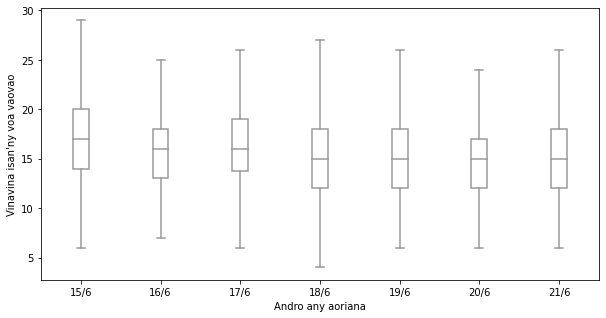

In [37]:
# Plotting boundaries for the next 7 days

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_hoav_lst, data_hoav, color='white', width=0.2, showfliers=False, ax=ax)

ax.set_xlabel('Andro any aoriana')
ax.set_ylabel("Vinavina isan'ny voa vaovao")

plt.savefig(path_to_save+'Ivbo146hoav_toam.eps')

plt.show()

In [38]:
daty_ohv = datetime.date(2020,6,16)

print("Vinavina R hoan'ny", daty_ohv, ':', Rt_salan(daty_ohv))
print("Vinavina kartily @ 75% R hoan'ny", daty_ohv, ':', perc75(daty_ohv))
print("Vinavina kartily @ 25% R hoan'ny", daty_ohv, ':', perc25(daty_ohv))
print("Vinavina isan'ny voa vaovao hoan'ny", daty_ohv, ':', dIvao.loc[format_date(daty_ohv)])

print("Vinavina kartily @ 75% R hoan'ny", daty_ohv, ':', poisson.ppf(0.95, dIvao.loc[format_date(daty_ohv)]))
print("Vinavina kartily @ 25% R hoan'ny", daty_ohv, ':', poisson.ppf(0.25, dIvao.loc[format_date(daty_ohv)]))

Vinavina R hoan'ny 2020-06-16 : 0.8582949043508195
Vinavina kartily @ 75% R hoan'ny 2020-06-16 : 0.9054168687975411
Vinavina kartily @ 25% R hoan'ny 2020-06-16 : 0.8090062087042346
Vinavina isan'ny voa vaovao hoan'ny 2020-06-16 : Voatomb    16.0
Name: 2020-06-16 00:00:00, dtype: float64
Vinavina kartily @ 75% R hoan'ny 2020-06-16 : [23.]
Vinavina kartily @ 25% R hoan'ny 2020-06-16 : [13.]
